# 2 Getting Started
***

In [3]:
# ActiveRegion is the main class - it has access to segmentation methods,
# Physical features and fields
from solarmask.active_region import ActiveRegion

# Usefull if you don't want to manually find datetimes, get_dates
# finds all the dates for a given harpnumber
from solarmask.data import get_dates

For any active region, all you need is a **harpnumber** **root** and **date**

Root is the entry point into your data. Root is designed to read from two folders: 

    - root/magnetogram
    - root/continuum
    
In each of these folders, there should be a list of harpnumber directories labeled sharp_\<harpnumber\>:

    - root/magnetogram
        - sharp_1
        - sharp_2
        ...
    - root/magnetogram
        - sharp_1
        - sharp_2
        
In each of these subfolders, there should be a list of active regions. In magnetogram, there is a bz, br and bp component and continuum has a single continuum component using the following naming convention:
    
    - root/magnetogram
        - sharp_1
            - hmi.sharp_cea_720s.<harpnumber>.<yyyy><mm><dd>_<hh><mm><ss>_TAI.Bp.fits
            - hmi.sharp_cea_720s.<harpnumber>.<yyyy><mm><dd>_<hh><mm><ss>_TAI.Br.fits
            - hmi.sharp_cea_720s.<harpnumber>.<yyyy><mm><dd>_<hh><mm><ss>_TAI.Bt.fits
    - root/continuum
        - sharp_1
            - hmi.sharp_cea_720s.<harpnumber>.<yyyy><mm><dd>_<hh><mm><ss>_TAI.continuum.fits

For example:

    - root/magnetogram
        - sharp_7115
            - hmi.sharp_cea_720s.7115.20170903_100000_TAI.Bp.fits
            - hmi.sharp_cea_720s.7115.20170903_100000_TAI.Br.fits
            - hmi.sharp_cea_720s.7115.20170903_100000_TAI.Bt.fits

    - root/continuum
        - sharp_7115
            - hmi.sharp_cea_720s.7115.20170903_100000_TAI.continuum.fits

In [4]:
hnum = 7115 
root = "../example_data/raw"
dates = get_dates(hnum, root, sort = True) # If you don't want to manually put in dates - extract all possible dates

print("First date: ", dates[0])
print("Last date: ", dates[-1])
print("Num dates: ", len(dates))

First date:  2017-09-01 22:00:00
Last date:  2017-09-06 12:00:00
Num dates:  2


Then we can create an active region - the entry point into all of the library functions

In [5]:
ar = ActiveRegion(hnum, dates[1], root)
print(dates[1])

2017-09-06 12:00:00


And we can view each of the data elements pulled from the fits file:

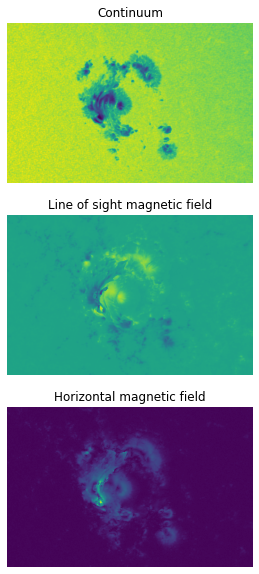

In [14]:
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

ax1.imshow(ar.cont)
ax1.set_title("Continuum")
ax1.axis(False)

ax2.imshow(ar.Bz)
ax2.set_title("Line of sight magnetic field")
ax2.axis(False)

ax3.imshow(ar.Bh)
ax3.set_title("Horizontal magnetic field")
ax3.axis(False)

fig.set_figheight(10)

plt.show()

## 2.2 Active Region Basics

An active region is designed using assertions. It automatically updates the data products it needs for various operations. That way, every computationally intensive method is only ever called once and the results are stored in memory. Therefore, there is no need to set up or imply various methods. Although this does mean the execution time of various functions is not always the same.

For example, if I want to create an active region, then get a data product (say baseline), I simply need to call get_baseline. The first call will take a while, but the next call will be instantaneous because AR already has the baseline data set:

In [17]:
import time

ar = ActiveRegion(hnum, dates[1], root)

start = time.time()
ar.segmented_dataset
end = time.time()
print("First time running segmented: ", end - start, " seconds - notice it's large")

start = time.time()
ar.segmented_dataset
end = time.time()
print("Second time running segmented: ", end - start, " seconds - notice it's small because we got it once before")

start = time.time()
ar.baseline_dataset
end = time.time()
print("Getting baseline : ", end - start, " seconds")

First time running segmented:  0.35760951042175293  seconds - notice it's large
Second time running segmented:  2.288818359375e-05  seconds - notice it's small because we got it once before
Getting baseline :  0.048726558685302734  seconds


So the only time intensive method is the first one that's called. Everything else is instantaneous. If you want to understand the time ellapsed, you can simply call ar.assert_masks(). This is a high level function that "does everything" to initialize the active region. But you really never need to call this method because every method that needs a mask calls it.

### Visualization

You can show the umbras, penumbras neutral lines backgrounds and graphs side by side with the original image:

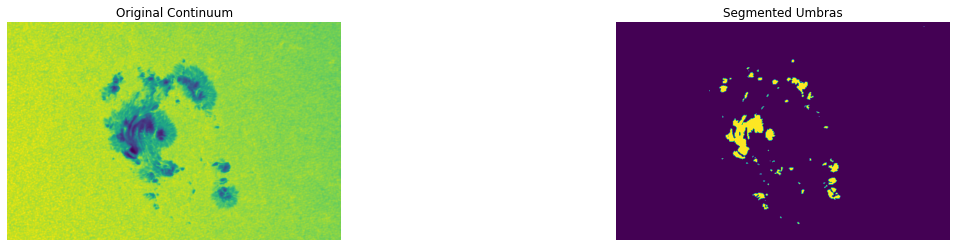

In [19]:
ar = ActiveRegion(hnum, dates[1], root)

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(ar.cont)
ax1.axis(False)
ax1.set_title("Original Continuum")

ax2.imshow(ar.umbra_mask)
ax2.axis(False)
ax2.set_title("Segmented Umbras")

fig.set_figwidth(20)
fig.set_figwidth(20)

plt.show()

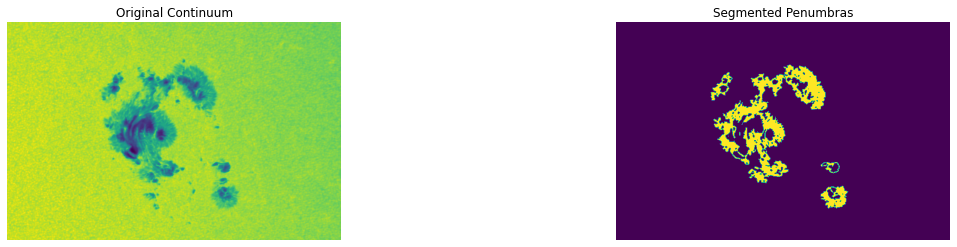

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(ar.cont)
ax1.axis(False)
ax1.set_title("Original Continuum")

ax2.imshow(ar.penumbra_mask)
ax2.axis(False)
ax2.set_title("Segmented Penumbras")

fig.set_figwidth(20)
fig.set_figwidth(20)

plt.savefig("./outputs/penumbras.png")
plt.show()

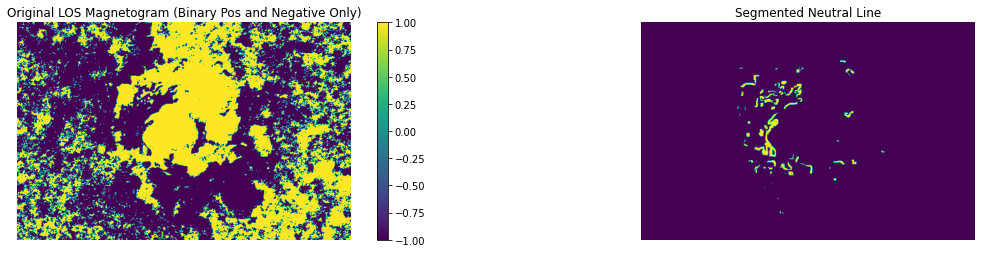

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2)

Bz = ar.Bz.copy()
Bz[Bz > 0] = 1
Bz[Bz < 0] = -1
pcm = ax1.imshow(Bz)
ax1.axis(False)
ax1.set_title("Original LOS Magnetogram (Binary Pos and Negative Only)")
fig.colorbar(pcm, ax = ax1)

ax2.imshow(ar.nl_mask)
ax2.axis(False)
ax2.set_title("Segmented Neutral Line")

fig.set_figwidth(20)
fig.set_figwidth(20)

plt.savefig("./outputs/nl.png")
plt.show()

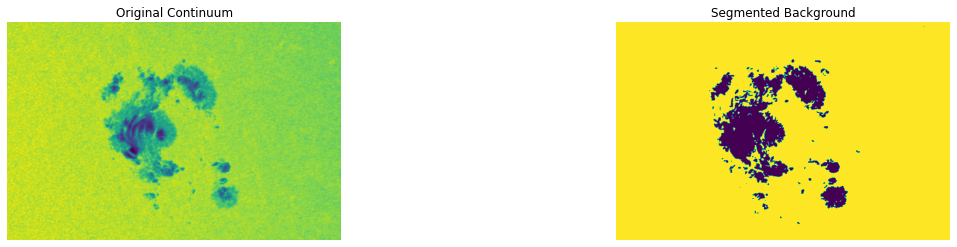

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(ar.cont)
ax1.axis(False)
ax1.set_title("Original Continuum")

ax2.imshow(ar.background_mask)
ax2.axis(False)
ax2.set_title("Segmented Background")

fig.set_figwidth(20)
fig.set_figwidth(20)

plt.savefig("./outputs/background.png")
plt.show()

### Datasets


There are four main datasets that you can get from ActiveRegion:

1. sharps - The 16 (or 32 if INCLUDE_ERRORS in data.py is True) physical features that JSOC extracts and stores in the header file
2. baseline - The 58 physical features I have included run on the entire image
3. segmented - The 58 physical features for each subsection stacked on top of each other (so a 232 dimensional vector)
4. graph - A networkx graph. Each node is connected to its neighbors and each node has an attribute (v) that encodes its physical feature vector (58 dimensions)

Each call to get_<dataset> returns an (array, label) for the array and the label for each value in the array. Note in segmented, if a certain subset doesn't exist, the values in the array will be 0 and the labels will be empty

#### SHARP
Sharp features are those stored in each individual fits file by JSOC

Labels for sharps features are the same as those in JSOC http://jsoc.stanford.edu/doc/data/hmi/sharp/sharp.htm

In [30]:
print(ar.sharps_dataset)

{'USFLUX': 4.533103e+22, 'MEANGAM': 51.792, 'MEANGBT': 110.105, 'MEANGBZ': 126.385, 'MEANGBH': 76.954, 'MEANJZD': -0.31327546, 'TOTUSJZ': 100571700000000.0, 'MEANALP': -0.06190259, 'MEANJZH': -0.03697439, 'TOTUSJH': 7357.481, 'ABSNJZH': 2271.374, 'SAVNCPP': 78371730000000.0, 'MEANPOT': 21630.71, 'TOTPOT': 1.764815e+24, 'MEANSHR': 45.785, 'SHRGT45': 47.17}


#### Baseline
Baseline is the result of calling ar.physical_features on the entire active region 2d array (ie the mask is all true). This is a 58 dimensional vector

Labels for baseline follow the convention:

    - bas_<property>_<moment label (if any)>

For example, the skew of the shear field and the total free energy would be (respectively):

    - bas_shear_skew, bas_totrho

In [31]:
print(ar.baseline_dataset)

{'Bz_tot': 48436571.73000002, 'Bz_totabs': 912665.0699999997, 'itot': 1158731875.8816144, 'itotabs': 513884.65279076196, 'itot_polarity': 69741420.32692963, 'ihtot': 260424630525.3697, 'ihtotabs': 3658852029.034691, 'hctot': 346536044344.56824, 'hctotabs': 152841919638.9422, 'totrho': 21887487.611776374, 'Bz_mean': 2.9610447920992518, 'Bz_std': 353.91205722553934, 'Bz_skew': 0.8624891360407722, 'Bz_kurt': 15.705697123960512, 'Bh_mean': 181.74443637163253, 'Bh_std': 301.11945941453774, 'Bh_skew': 4.275037651713445, 'Bh_kurt': 27.07156202696789, 'gamma_mean': -0.1003125604687583, 'gamma_std': 0.6785771694077445, 'gamma_skew': 0.20137146281062596, 'gamma_kurt': -1.0749836556997958, 'grad_B_mean': 49.819821037258365, 'grad_B_std': 72.48970397795553, 'grad_B_skew': 10.687045428877381, 'grad_B_kurt': 214.83928901171123, 'grad_Bz_mean': 51.636673855447874, 'grad_Bz_std': 81.89618924956946, 'grad_Bz_skew': 9.117129105709143, 'grad_Bz_kurt': 162.31031800893274, 'grad_Bh_mean': 37.43074113475015

#### Segmented
Baseline is the result of calling ar.physical_features on each individual segment of the active region and stacking neutral line, umbra, penumbra, background on top of each other

Labels for segmented follow the convention:

    - <region>_<property>_<moment label (if any)>

For example, the skew of the shear field for the neutral line and the total free energy for the background would be (respectively):

    - nl_shear_skew, bckg_totrho

In [32]:
print(ar.segmented_dataset)

{'nl_Bz_tot': 1730154.0, 'nl_Bz_totabs': 74285.20000000001, 'nl_itot': 72911186.77918473, 'nl_itotabs': 5502452.308782724, 'nl_itot_polarity': 8855326.523065047, 'nl_ihtot': 77831129621.29727, 'nl_ihtotabs': 246844235.33597994, 'nl_hctot': 57063866401.77635, 'nl_hctotabs': 12216768812.036888, 'nl_totrho': 6131235.380608724, 'nl_Bz_mean': -18.233971526755035, 'nl_Bz_std': 723.3068414530032, 'nl_Bz_skew': -0.5455602300328546, 'nl_Bz_kurt': 5.615103176236618, 'nl_Bh_mean': 1132.8273410495333, 'nl_Bh_std': 851.3247532920949, 'nl_Bh_skew': 1.189955019812326, 'nl_Bh_kurt': 1.2650226810732885, 'nl_gamma_mean': 0.0018664835082713447, 'nl_gamma_std': 0.5023637771433762, 'nl_gamma_skew': 0.09755952858633657, 'nl_gamma_kurt': 0.6208295788868163, 'nl_grad_B_mean': 250.90027949302583, 'nl_grad_B_std': 349.3953113840282, 'nl_grad_B_skew': 3.0308016114527065, 'nl_grad_B_kurt': 10.88481453737684, 'nl_grad_Bz_mean': 344.88730013572416, 'nl_grad_Bz_std': 383.2043553122473, 'nl_grad_Bz_skew': 2.604300650